# Exploratory Data Analysis

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd

import json
import csv

import os
import requests

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#set plot styles
sns.set_style("whitegrid")
sns.set_palette("husl")

In [3]:
#retrieve test data from 2015-2019
r = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=9447cd662f95276c1c7a053a8d830e7a&language=en-US&region=US&sort_by=revenue.desc&include_adult=false&include_video=false&release_date.gte=2015-01-01&release_date.lte=2019-12-31&with_release_type=3&vote_count.gte=100')
data = r.json()
pages = data['total_pages']
#create a list of all movie IDs from the release range
movies = []
for i in range(1,pages+1):
    r = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=9447cd662f95276c1c7a053a8d830e7a&language=en-US&region=US&sort_by=revenue.desc&include_adult=false&include_video=false&release_date.gte=2015-01-01&release_date.lte=2019-12-31&with_release_type=3&vote_count.gte=100&page=' + str(i))
    data = r.json()
    results = len(data['results'])
    for j in range(results):
        movies.append(data['results'][j]['id'])

In [7]:
#create a list of dictionaries to convert into a dataframe
data_frame = []
for i in range(len(movies)):
    movie_id = str(movies[i])
    
    #retrieve movie details
    r = requests.get('https://api.themoviedb.org/3/movie/' + movie_id + '?api_key=9447cd662f95276c1c7a053a8d830e7a&language=en-US')
    data = r.json()
    movie_budget = data['budget']
    movie_production = np.nan
    if len(data['production_companies']):
        movie_production = data['production_companies'][0]['name']
    movie_release = data['release_date']
    movie_revenue = data['revenue']
    movie_runtime = data['runtime']
    movie_genre = data['genres'][0]['name']
    movie_popularity = data['popularity']
    movie_votecount = data['vote_count']
    movie_voteavg = data['vote_average']
    
    #retrieve keywords associated with the movie
    r = requests.get('https://api.themoviedb.org/3/movie/' + movie_id + '/keywords?api_key=9447cd662f95276c1c7a053a8d830e7a')
    keywords = r.json()
    keywords
    keyword = []
    if len(keywords['keywords']) < 2:
        count = 0
        for i in range(len(keywords['keywords'])):
            keyword.append(keywords['keywords'][i]['name'])
            count += 1
        while count < 2:
            keyword.append(np.nan)
            count += 1
    else:
        for i in range(len(keywords['keywords'])):
            keyword.append(keywords['keywords'][i]['name'])
    
    #create dictionary for the movie 
    movie_dict = {'id': movie_id, 'genre': movie_genre, 'keyword1': keyword[0], 'keyword2': keyword[1], 'budget': movie_budget, 'production': movie_production, 'runtime': movie_runtime, 'popularity': movie_popularity, 'vote_count': movie_votecount, 'vote_average': movie_voteavg, 'revenue': movie_revenue}
    data_frame.append(movie_dict)
    
df = pd.DataFrame(data_frame)
#drop null and incorrect values
df = df.dropna().loc[df['revenue']>0].loc[df['budget']>0]
#normalize values
#categorize revenues
df['revenue'] = df['revenue'].apply(lambda x: x//1000000)
df['budget'] = df['budget'].apply(lambda x: x//1000000)
df['revenue_category'] = pd.cut(df['revenue'], bins=[-1, 2, 15, 40, 95, 250, 10000], labels = ['<2M', '2M-15M', '15M-40M', '40M-95M', '95M-250M', '>250M'])
#save pandas dataframe to csv
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv('eda.csv', index = None, header=True)

In [8]:
data = pd.read_csv('eda.csv')
data

,id,genre,keyword1,keyword2,budget,production,runtime,popularity,vote_count,vote_average,revenue,revenue_category
0,238713,Action,spy,cia,65,Chernin Entertainment,120.0,22.020,4339,6.8,235,95M-250M
1,324849,Action,superhero,based on comic,80,Lin Pictures,104.0,14.214,3319,7.2,311,>250M
2,429197,Drama,washington d.c.,the white house,60,Plan B Entertainment,132.0,17.618,1984,7.1,76,40M-95M
3,290595,Action,witch,magic,115,Roth Films,114.0,23.062,3410,6.2,164,95M-250M
4,369883,Family,school,middle school,8,Lionsgate,92.0,9.609,248,7.0,23,15M-40M
...,...,...,...,...,...,...,...,...,...,...,...,...
710,330459,Action,rebel,spacecraft,200,Lucasfilm,133.0,30.473,10737,7.5,1056,>250M
711,300668,Science Fiction,coma,based on novel or book,40,DNA Films,115.0,27.472,5459,6.3,43,40M-95M
712,440642,Adventure,usa,spacecraft,7,Bazelevs Production,140.0,11.796,183,7.2,9,2M-15M
713,278924,Action,assassin,enemy,40,Davis-Films,99.0,17.657,2098,5.7,125,95M-250M


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


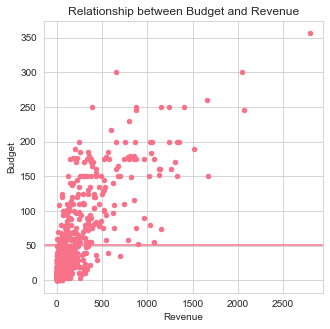

In [13]:
data.plot(x="revenue",y="budget", kind="scatter",figsize=(5,5))
budget_mean = np.mean(data.budget)
plt.axhline(y=budget_mean)
plt.title("Relationship between Budget and Revenue")
plt.xlabel("Revenue", size=10)
plt.ylabel("Budget", size=10)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


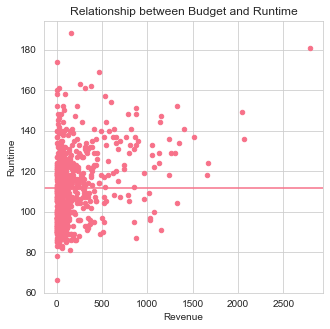

In [14]:
data.plot(x="revenue", y="runtime", kind="scatter",figsize=(5,5))
runtime_mean = np.mean(data.runtime)
plt.axhline(y=runtime_mean)
plt.title("Relationship between Budget and Runtime")
plt.xlabel("Revenue", size=10)
plt.ylabel("Runtime", size=10)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


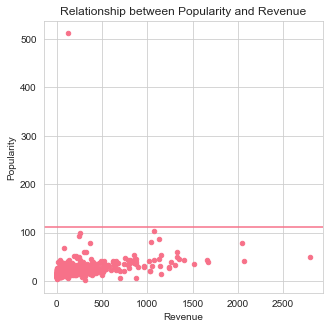

In [19]:
data.plot(x="revenue", y="popularity", kind="scatter",figsize=(5,5))
runtime_mean = np.mean(data.runtime)
plt.axhline(y=runtime_mean)
plt.title("Relationship between Popularity and Revenue")
plt.xlabel("Revenue", size=10)
plt.ylabel("Popularity", size=10)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


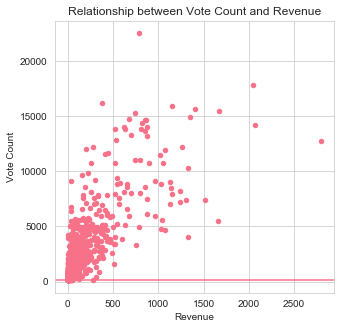

In [20]:
data.plot(x="revenue", y="vote_count", kind="scatter",figsize=(5,5))
runtime_mean = np.mean(data.runtime)
plt.axhline(y=runtime_mean)
plt.title("Relationship between Vote Count and Revenue")
plt.xlabel("Revenue", size=10)
plt.ylabel("Vote Count", size=10)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


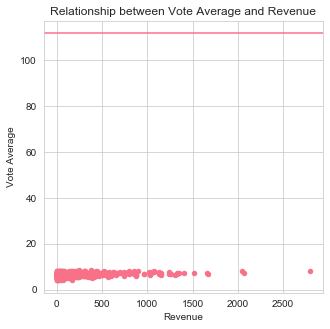

In [23]:
data.plot(x="revenue", y="vote_average", kind="scatter",figsize=(5,5))
runtime_mean = np.mean(data.runtime)
plt.axhline(y=runtime_mean)
plt.title("Relationship between Vote Average and Revenue")
plt.xlabel("Revenue", size=10)
plt.ylabel("Vote Average", size=10)
plt.show()